<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# 双重机器学习：用例与示例

双重机器学习（DML）是一种算法，它应用任意机器学习方法来拟合处理（treatment）和响应（response），然后使用线性模型根据处理残差来预测响应残差。

EconML SDK 实现了以下 DML 类：
*   线性DML (LinearDML)：适用于估计异质性处理效应。
*   稀疏线性DML (SparseLinearDML)：适用于当 $W$ 是高维向量，且第一阶段和第二阶段的估计均为线性的情况。

在本Notebook中，我们将展示 DML 在合成数据和观测数据上的性能表现。

**Notebook内容：**

1.  使用单一连续型处理的合成数据示例
2.  使用单一二元型处理的合成数据示例
3.  使用多个连续型处理的合成数据示例
4.  使用单一连续型处理的观测数据示例
5.  使用多个连续型处理、多个结果的观测数据示例

In [1]:
## Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Main imports
from econml.dml import DML, LinearDML, SparseLinearDML, CausalForestDML

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import (Lasso, MultiTaskElasticNetCV)
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

## 1. 使用单一连续型处理的合成数据与模型选择示例
### 1.1. 数据生成过程 (DGP)
我们使用来自[此文](https://arxiv.org/abs/1806.03467)的数据生成过程 (DGP)。该数据生成过程由以下方程描述：

\begin{align}
T =& \langle W, \beta\rangle + \eta, & \;\eta \sim \text{Uniform}(-1, 1)\\
Y =& T\cdot \theta(X) + \langle W, \gamma\rangle + \epsilon, &\; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim& \text{Normal}(0,\, I_{n_w})\\
X \sim& \text{Uniform}(0,1)^{n_x}
\end{align}

其中 $W$ 是高维混杂因素矩阵，$\beta$ 和 $\gamma$ 具有高度稀疏性。

对于此数据生成过程，
\begin{align}
\theta(x) = \exp(2\cdot x_1).
\end{align}

In [3]:
# Treatment effect function
def exp_te(x):
    return np.exp(2*x[0])

In [4]:
# DGP constants
np.random.seed(123)
n = 2000
n_w = 30
support_size = 5
n_x = 1
# Outcome support
support_Y = np.random.choice(np.arange(n_w), size=support_size, replace=False)
coefs_Y = np.random.uniform(0, 1, size=support_size)
def epsilon_sample(n):
    return np.random.uniform(-1, 1, size=n)
# Treatment support
support_T = support_Y
coefs_T = np.random.uniform(0, 1, size=support_size)
def eta_sample(n):
    return np.random.uniform(-1, 1, size=n)

# Generate controls, covariates, treatments and outcomes
W = np.random.normal(0, 1, size=(n, n_w))
X = np.random.uniform(0, 1, size=(n, n_x))
# Heterogeneous treatment effects
TE = np.array([exp_te(x_i) for x_i in X])
T = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
Y = TE * T + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)

Y_train, Y_val, T_train, T_val, X_train, X_val, W_train, W_val = train_test_split(Y, T, X, W, test_size=.2)
# Generate test data
X_test = np.array(list(product(np.arange(0, 1, 0.01), repeat=n_x)))

### 1.2. 训练估计器
我们以三种不同的方式训练模型，并比较它们的性能。

#### 1.2.1. 默认设置

In [5]:
est = LinearDML(model_y=RandomForestRegressor(),
                model_t=RandomForestRegressor(),
                random_state=123)
est.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred = est.effect(X_test)

#### 1.2.2. 用于异质性的多项式特征

In [6]:
est1 = SparseLinearDML(model_y=RandomForestRegressor(),
                       model_t=RandomForestRegressor(),
                       featurizer=PolynomialFeatures(degree=3),
                       random_state=123)
est1.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred1 = est1.effect(X_test)

#### 1.2.3. 带正则化的多项式特征

In [7]:
est2 = DML(model_y=RandomForestRegressor(),
           model_t=RandomForestRegressor(),
           model_final=Lasso(alpha=0.1, fit_intercept=False),
           featurizer=PolynomialFeatures(degree=10),
           random_state=123)
est2.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred2 = est2.effect(X_test)

#### 1.2.4. 使用因果森林的非参数异质性

In [8]:
est3 = CausalForestDML(model_y=RandomForestRegressor(),
                       model_t=RandomForestRegressor(),
                       criterion='mse', n_estimators=1000,
                       min_impurity_decrease=0.001,
                       random_state=123)
est3.tune(Y_train, T_train, X=X_train, W=W_train)
est3.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred3 = est3.effect(X_test)

### 1.3. 性能可视化

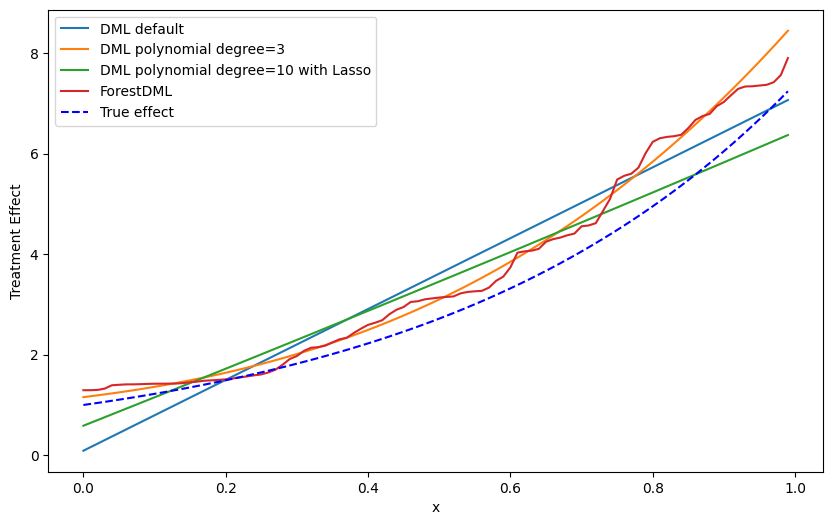

In [9]:
plt.figure(figsize=(10,6))
plt.plot(X_test, te_pred, label='DML default')
plt.plot(X_test, te_pred1, label='DML polynomial degree=3')
plt.plot(X_test, te_pred2, label='DML polynomial degree=10 with Lasso')
plt.plot(X_test, te_pred3, label='ForestDML')
expected_te = np.array([exp_te(x_i) for x_i in X_test])
plt.plot(X_test, expected_te, 'b--', label='True effect')
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.show()

### 1.4. 模型选择

对于上述三种不同的模型，我们可以使用评分函数来估计最终模型的性能。该评分是最后阶段 Y 残差的均方误差 (MSE)，可以将其视为处理效应均方误差 (MSE) 的代理指标。

In [10]:
score={}
score["DML default"] = est.score(Y_val, T_val, X_val, W_val)
score["DML polynomial degree=3"] = est1.score(Y_val, T_val, X_val, W_val)
score["DML polynomial degree=10 with Lasso"] = est2.score(Y_val, T_val, X_val, W_val)
score["ForestDML"] = est3.score(Y_val, T_val, X_val, W_val)
score

{'DML default': 2.180822372216379,
 'DML polynomial degree=3': 1.9430500314409858,
 'DML polynomial degree=10 with Lasso': 2.2215615665744846,
 'ForestDML': 1.8652762990444496}

In [11]:
print("best model selected by score: ",min(score,key=lambda x: score.get(x)))

best model selected by score:  ForestDML


In [12]:
mse_te={}
mse_te["DML default"] = ((expected_te - te_pred)**2).mean()
mse_te["DML polynomial degree=3"] = ((expected_te - te_pred1)**2).mean()
mse_te["DML polynomial degree=10 with Lasso"] = ((expected_te - te_pred2)**2).mean()
mse_te["ForestDML"] = ((expected_te - te_pred3)**2).mean()
mse_te

{'DML default': 0.4660750771378623,
 'DML polynomial degree=3': 0.36550168169517755,
 'DML polynomial degree=10 with Lasso': 0.25708323741777234,
 'ForestDML': 0.3207732594329821}

In [13]:
print("best model selected by MSE of TE: ", min(mse_te, key=lambda x: mse_te.get(x)))

best model selected by MSE of TE:  DML polynomial degree=10 with Lasso


### 1.5. 仅更改最后阶段模型设定并重新拟合

更改估计器的参数，并仅使用现有的第一阶段残差计算来拟合最后阶段模型也是可行的。为启用此功能，`fit` 方法应使用 `cache_values=True` 标志进行调用，以便将原始拟合数据及其对应的第一阶段估计值存储在模型中。这可以对 dml 模块中的任何估计器执行。我们在下面使用 `DML` 估计器展示一个示例。

In [14]:
est = DML(model_y=RandomForestRegressor(),
          model_t=RandomForestRegressor(),
          model_final=Lasso(alpha=0.1, fit_intercept=False),
          featurizer=PolynomialFeatures(degree=1, include_bias=False),
          random_state=123)
est.fit(Y_train, T_train, X=X_train, W=W_train, cache_values=True)
est.summary()

,point_estimate
X0,5.96
,point_estimate
cate_intercept,0.501


In [15]:
from econml.sklearn_extensions.linear_model import DebiasedLasso
est.featurizer = PolynomialFeatures(degree=2, include_bias=False)
est.model_final = DebiasedLasso(fit_intercept=False)
est.refit_final()
est.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,-0.176,0.69,-0.255,0.799,-1.528,1.176
X0^2,7.383,0.7,10.551,0.0,6.012,8.755
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,1.312,0.155,8.453,0.0,1.007,1.616


In [16]:
from econml.sklearn_extensions.linear_model import StatsModelsLinearRegression
est.model_final = StatsModelsLinearRegression(fit_intercept=False)
est.refit_final()
est.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,-0.197,0.763,-0.259,0.796,-1.693,1.298
X0^2,7.396,0.844,8.76,0.0,5.741,9.051
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,1.313,0.135,9.746,0.0,1.049,1.577


In [17]:
from econml.sklearn_extensions.linear_model import StatsModelsRLM
est.model_final = StatsModelsRLM(fit_intercept=False)
est.fit_cate_intercept = False
est.refit_final()
est.summary()

CATE Intercept Results:  No intercept was fitted!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,5.543,0.35,15.859,0.0,4.858,6.228
X0^2,2.291,0.454,5.051,0.0,1.402,3.18


In [18]:
est.model_final = Lasso(fit_intercept=False)
est.refit_final()
est.effect_inference(X).population_summary()

## 2. 使用单一二元处理的合成数据与置信区间示例

### 2.1. 数据生成过程 (DGP)
我们使用以下数据生成过程 (DGP)：

\begin{align}
T \sim & \text{Bernoulli}\left(f(W)\right), &\; f(W)=\sigma(\langle W, \beta\rangle + \eta), \;\eta \sim \text{Uniform}(-1, 1)\\
Y = & T\cdot \theta(X) + \langle W, \gamma\rangle + \epsilon, & \; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim & \text{Normal}(0,\, I_{n_w}) & \\
X \sim & \text{Uniform}(0,\, 1)^{n_x}
\end{align}

其中 $W$ 是高维混杂因素矩阵，$\beta, \gamma$ 具有高度稀疏性，$\sigma$ 是 Sigmoid 函数。

对于此数据生成过程，
\begin{align}
\theta(x) = \exp( 2\cdot x_1 ).
\end{align}

In [19]:
# Treatment effect function
def exp_te(x):
    return np.exp(2 * x[0])# DGP constants

np.random.seed(123)
n = 1000
n_w = 30
support_size = 5
n_x = 4
# Outcome support
support_Y = np.random.choice(range(n_w), size=support_size, replace=False)
coefs_Y = np.random.uniform(0, 1, size=support_size)
def epsilon_sample(n):
    return np.random.uniform(-1, 1, size=n)
# Treatment support
support_T = support_Y
coefs_T = np.random.uniform(0, 1, size=support_size)
def eta_sample(n):
    return np.random.uniform(-1, 1, size=n)

# Generate controls, covariates, treatments and outcomes
W = np.random.normal(0, 1, size=(n, n_w))
X = np.random.uniform(0, 1, size=(n, n_x))
# Heterogeneous treatment effects
TE = np.array([exp_te(x_i) for x_i in X])
# Define treatment
log_odds = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
T_sigmoid = 1/(1 + np.exp(-log_odds))
T = np.array([np.random.binomial(1, p) for p in T_sigmoid])
# Define the outcome
Y = TE * T + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)

# get testing data
X_test = np.random.uniform(0, 1, size=(n, n_x))
X_test[:, 0] = np.linspace(0, 1, n)

### 2.2. 训练估计器

In [20]:
est = LinearDML(model_y=RandomForestRegressor(),
                model_t=RandomForestClassifier(min_samples_leaf=10),
                discrete_treatment=True,
                cv=6)
est.fit(Y, T, X=X, W=W)
te_pred = est.effect(X_test)
lb, ub = est.effect_interval(X_test, alpha=0.01)

In [21]:
est2 = SparseLinearDML(model_y=RandomForestRegressor(),
                       model_t=RandomForestClassifier(min_samples_leaf=10),
                       discrete_treatment=True,
                       featurizer=PolynomialFeatures(degree=2),
                       cv=6)
est2.fit(Y, T, X=X, W=W)
te_pred2 = est2.effect(X_test)
lb2, ub2 = est2.effect_interval(X_test, alpha=0.01)

In [22]:
est3 = CausalForestDML(model_y=RandomForestRegressor(),
                       model_t=RandomForestClassifier(min_samples_leaf=10),
                       discrete_treatment=True,
                       n_estimators=1000,
                       min_impurity_decrease=0.001,
                       verbose=0,
                       cv=6)
est3.tune(Y, T, X=X, W=W)
est3.fit(Y, T, X=X, W=W)
te_pred3 = est3.effect(X_test)
lb3, ub3 = est3.effect_interval(X_test, alpha=0.01)

In [23]:
est3.feature_importances_

array([0.99120539, 0.00259601, 0.0028019 , 0.0033967 ])

### 2.3. 性能可视化

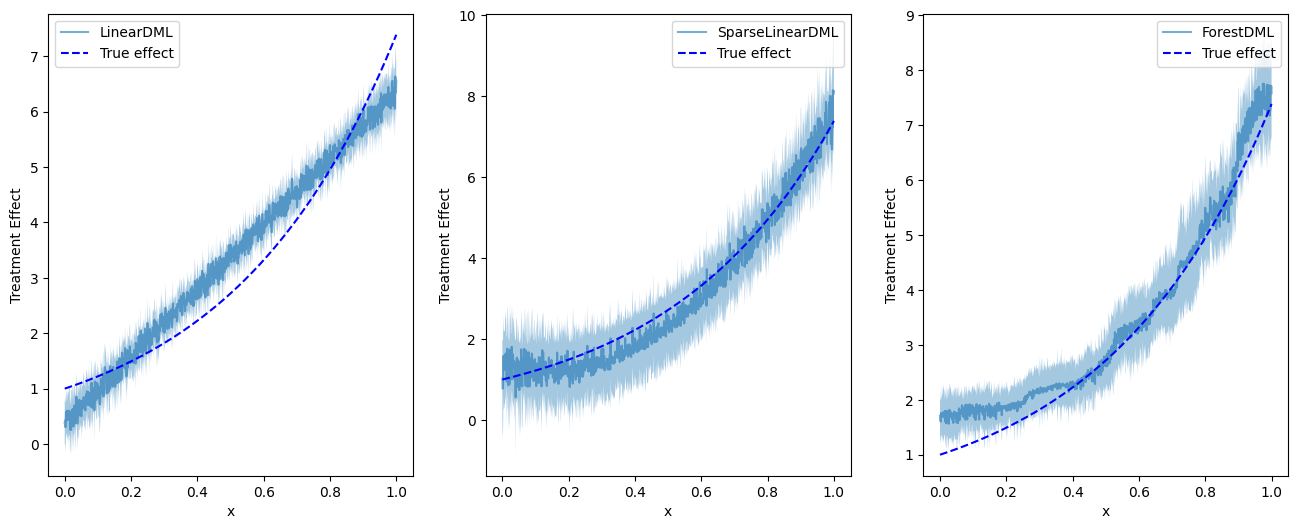

In [24]:
expected_te=np.array([exp_te(x_i) for x_i in X_test])
plt.figure(figsize=(16,6))
plt.subplot(1, 3, 1)
plt.plot(X_test[:, 0], te_pred, label='LinearDML', alpha=.6)
plt.fill_between(X_test[:, 0], lb, ub, alpha=.4)
plt.plot(X_test[:, 0], expected_te, 'b--', label='True effect')
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(X_test[:, 0], te_pred2, label='SparseLinearDML', alpha=.6)
plt.fill_between(X_test[:, 0], lb2, ub2, alpha=.4)
plt.plot(X_test[:, 0], expected_te, 'b--', label='True effect')
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(X_test[:, 0], te_pred3, label='ForestDML', alpha=.6)
plt.fill_between(X_test[:, 0], lb3, ub3, alpha=.4)
plt.plot(X_test[:, 0], expected_te, 'b--', label='True effect')
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.show()


### 2.4. 使用 SHAP 值进行可解释性分析

使用<a href="https://shap.readthedocs.io/en/latest/">SHAP 值</a>解释处理的恒定边际效应的异质性模型。

In [25]:
import shap

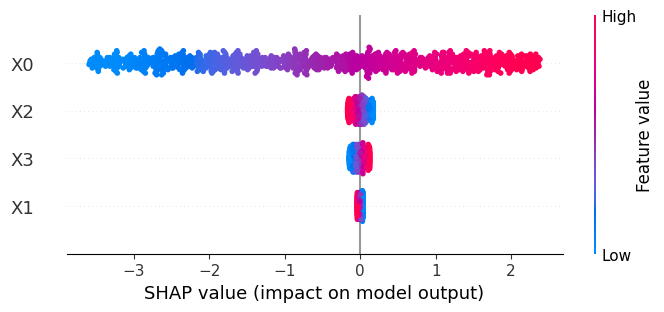

In [26]:
shap_values = est.shap_values(X)
shap.plots.beeswarm(shap_values['Y0']['T0_1'])

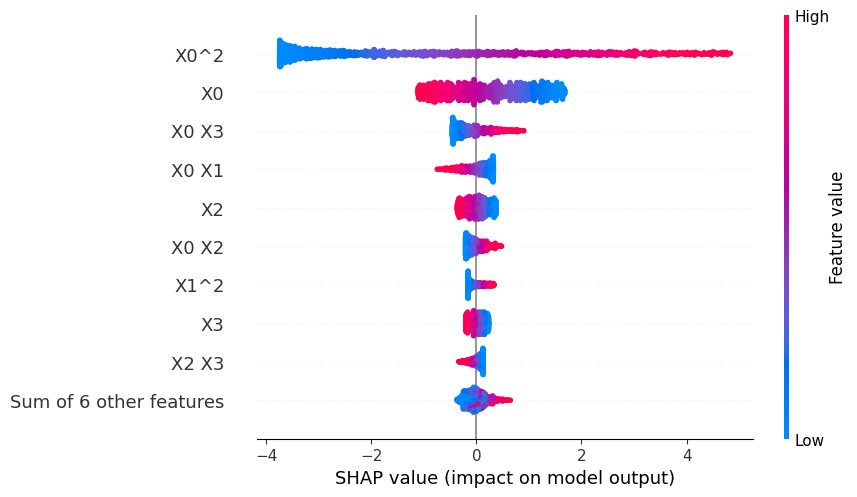

In [27]:
shap_values2 = est2.shap_values(X)
shap.plots.beeswarm(shap_values2['Y0']['T0_1'])

 99%|===================| 987/1000 [00:36<00:00]        

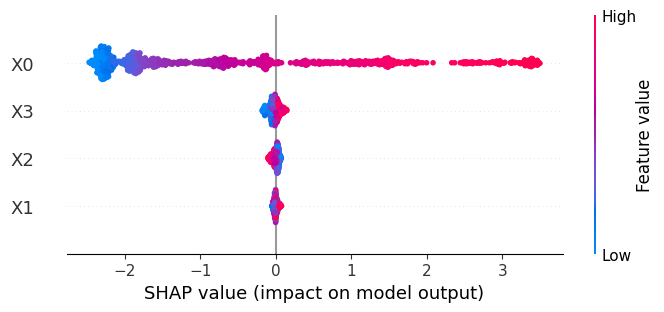

In [28]:
shap_values3 = est3.shap_values(X)
shap.plots.beeswarm(shap_values3['Y0']['T0_1'])
plt.show()

### 2.5. 其他推断
#### 2.5.1. 效应推断
除了置信区间外，我们还可以输出效应的其他统计推断，包括给定每个样本 $X[i]$ 的标准误差、z 检验得分和 p 值。

In [29]:
est.effect_inference(X_test[:10,]).summary_frame(alpha=0.1, value=0, decimals=3)

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,0.378,0.146,2.587,0.010,0.138,0.618
1,0.425,0.163,2.609,0.009,0.157,0.693
2,0.303,0.170,1.788,0.074,0.024,0.583
3,0.396,0.150,2.645,0.008,0.150,0.642
4,0.581,0.152,3.810,0.000,0.330,0.832
5,0.549,0.139,3.946,0.000,0.320,0.778
6,0.427,0.124,3.449,0.001,0.223,0.630
7,0.602,0.154,3.904,0.000,0.348,0.855
8,0.432,0.126,3.421,0.001,0.224,0.640


我们还可以获得给定样本 $X$ 的总体推断。

In [30]:
est.effect_inference(X_test).population_summary(alpha=0.1, value=0, decimals=3, tol=0.001)

#### 2.5.2. 系数和截距推断
当最终模型为线性模型时，我们还可以获得其系数和截距的推断。

In [31]:
est.coef__inference().summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
X0,5.981,0.229,26.135,0.000,5.533,6.430
X1,-0.080,0.216,-0.371,0.711,-0.502,0.342
X2,-0.344,0.218,-1.579,0.114,-0.770,0.083
X3,0.276,0.212,1.302,0.193,-0.139,0.691


In [32]:
est.intercept__inference().summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
cate_intercept,0.45,0.217,2.074,0.038,0.025,0.876


In [33]:
est.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,5.981,0.229,26.135,0.0,5.533,6.43
X1,-0.08,0.216,-0.371,0.711,-0.502,0.342
X2,-0.344,0.218,-1.579,0.114,-0.77,0.083
X3,0.276,0.212,1.302,0.193,-0.139,0.691
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,0.45,0.217,2.074,0.038,0.025,0.876


#### 2.5.3. 双重稳健平均处理效应推断

对于 `CausalForestDML` 的情况，估计器在拟合时也会拟合双重稳健的平均处理效应。此推断结果可以通过以下方式访问：

In [34]:
est3.ate_

array([3.55186651])

In [35]:
est3.ate__inference().summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
ATE,3.552,0.08,44.371,0.0,3.395,3.709


## 3. 使用多重连续型处理的合成数据示例

### 3.1. 数据生成过程 (DGP)
我们使用来自[此文](https://arxiv.org/abs/1806.03467)的数据生成过程 (DGP)，并修改处理以生成多重处理。该数据生成过程由以下方程描述：


\begin{align}
T =& \langle W, \beta\rangle + \eta, & \;\eta \sim \text{Uniform}(-1, 1)\\
Y =& T\cdot \theta_{1}(X) + T^{2}\cdot \theta_{2}(X) + \langle W, \gamma\rangle + \epsilon, &\; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim& \text{Normal}(0,\, I_{n_w})\\
X \sim& \text{Uniform}(0,1)^{n_x}
\end{align}

其中 $W$ 是高维混杂因素矩阵，$\beta, \gamma$ 具有高度稀疏性。

对于此数据生成过程，
\begin{align}
\theta_{1}(x) = \exp(2\cdot x_1)\\
\theta_{2}(x) = x_1^{2}\\
\end{align}

In [36]:
# DGP constants
np.random.seed(123)
n = 6000
n_w = 30
support_size = 5
n_x = 5
# Outcome support
support_Y = np.random.choice(np.arange(n_w), size=support_size, replace=False)
coefs_Y = np.random.uniform(0, 1, size=support_size)
def epsilon_sample(n):
    return np.random.uniform(-1, 1, size=n)
# Treatment support
support_T = support_Y
coefs_T = np.random.uniform(0, 1, size=support_size)
def eta_sample(n):
    return np.random.uniform(-1, 1, size=n)

# Generate controls, covariates, treatments and outcomes
W = np.random.normal(0, 1, size=(n, n_w))
X = np.random.uniform(0, 1, size=(n, n_x))
# Heterogeneous treatment effects
TE1 = np.array([x_i[0] for x_i in X])
TE2 = np.array([x_i[0]**2 for x_i in X]).flatten()
T = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
Y = TE1 * T + TE2 * T**2 + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)
# Generate test data
X_test = np.random.uniform(0, 1, size=(100, n_x))
X_test[:, 0] = np.linspace(0, 1, 100)

### 3.2. 训练估计器

In [37]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
est = LinearDML(model_y=GradientBoostingRegressor(n_estimators=100, max_depth=3, min_samples_leaf=20),
                model_t=MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100,
                                                                       max_depth=3,
                                                                       min_samples_leaf=20)),
                featurizer=PolynomialFeatures(degree=2, include_bias=False),
                cv=5)

In [38]:
T = T.reshape(-1,1)
est.fit(Y, np.concatenate((T, T**2), axis=1), X=X, W=W)

In [39]:
te_pred = est.const_marginal_effect(X_test)

In [40]:
lb, ub = est.const_marginal_effect_interval(X_test, alpha=0.01)

In [41]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
est2 = CausalForestDML(model_y=GradientBoostingRegressor(n_estimators=100, max_depth=3, min_samples_leaf=20),
                       model_t=MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100,
                                                                              max_depth=3,
                                                                              min_samples_leaf=20)),
                       cv=5,
                       criterion='mse', n_estimators=1000,
                       min_samples_leaf=10,
                       min_impurity_decrease=0.001,
                       random_state=123)
T = T.reshape(-1,1)
est2.tune(Y, np.concatenate((T, T**2), axis=1), X=X, W=W)
est2.fit(Y, np.concatenate((T, T**2), axis=1), X=X, W=W)

In [42]:
te_pred2 = est2.const_marginal_effect(X_test)

In [43]:
lb2, ub2 = est2.const_marginal_effect_interval(X_test, alpha=0.01)

### 3.3. 性能可视化

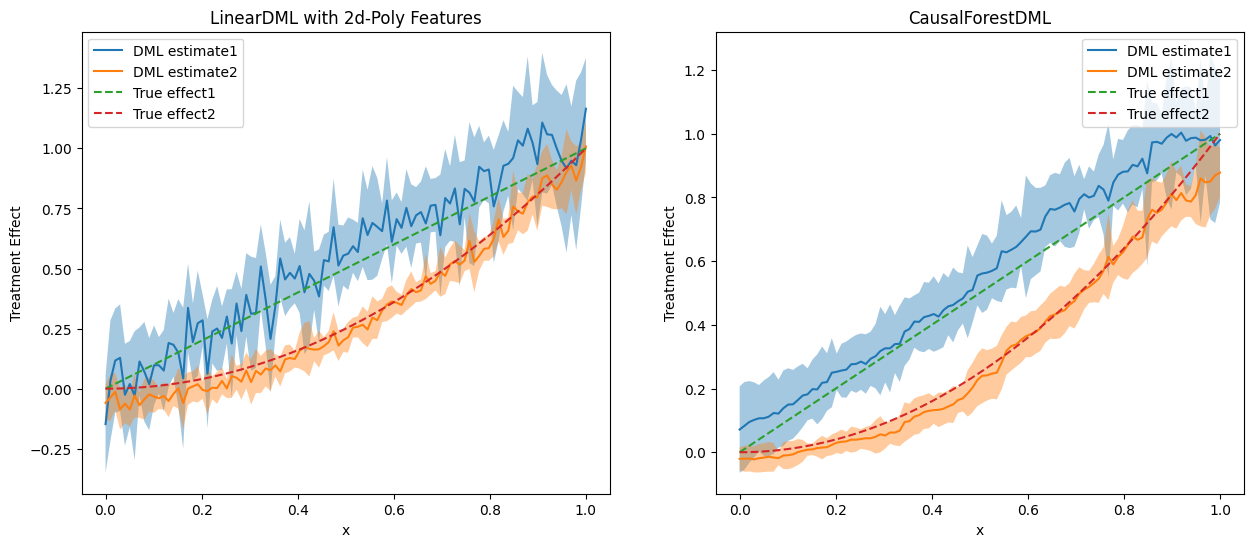

In [44]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title("LinearDML with 2d-Poly Features")
plt.plot(X_test[:, 0], te_pred[:, 0], label='DML estimate1')
plt.fill_between(X_test[:, 0], lb[:, 0], ub[:, 0], alpha=.4)
plt.plot(X_test[:, 0], te_pred[:, 1], label='DML estimate2')
plt.fill_between(X_test[:, 0], lb[:, 1], ub[:, 1], alpha=.4)
expected_te1 = np.array([x_i[0] for x_i in X_test])
expected_te2=np.array([x_i[0]**2 for x_i in X_test]).flatten()
plt.plot(X_test[:, 0], expected_te1, '--', label='True effect1')
plt.plot(X_test[:, 0], expected_te2, '--', label='True effect2')
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("CausalForestDML")
plt.plot(X_test[:, 0], te_pred2[:, 0], label='DML estimate1')
plt.fill_between(X_test[:, 0], lb2[:, 0], ub2[:, 0], alpha=.4)
plt.plot(X_test[:, 0], te_pred2[:, 1], label='DML estimate2')
plt.fill_between(X_test[:, 0], lb2[:, 1], ub2[:, 1], alpha=.4)
expected_te1 = np.array([x_i[0] for x_i in X_test])
expected_te2=np.array([x_i[0]**2 for x_i in X_test]).flatten()
plt.plot(X_test[:, 0], expected_te1, '--', label='True effect1')
plt.plot(X_test[:, 0], expected_te2, '--', label='True effect2')
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()
plt.show()

### 3.4. 树解释器

通过基于树的规则解释异质性。

In [45]:
from econml.cate_interpreter import SingleTreeCateInterpreter

intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2)
intrp.interpret(est, X)

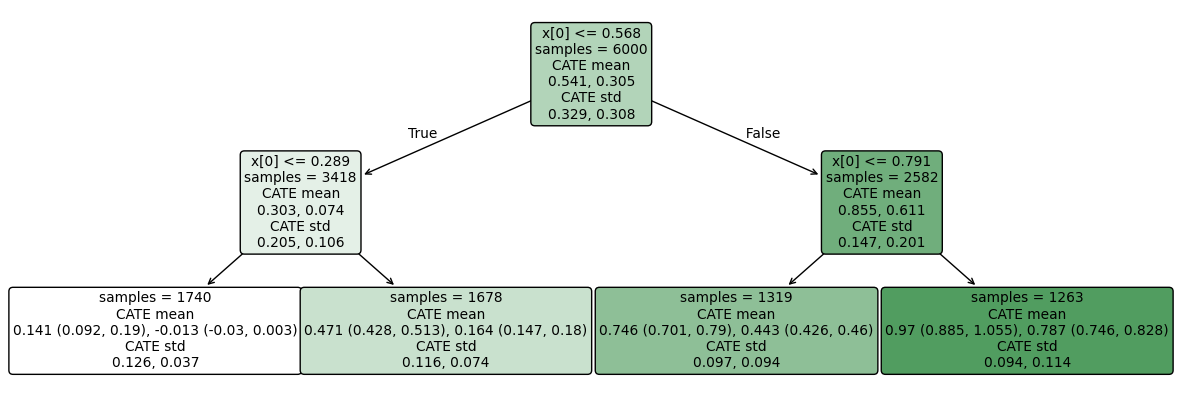

In [46]:
plt.figure(figsize=(15, 5))
intrp.plot()
plt.show()

## 4. 使用单一连续型处理的观测数据示例

我们将我们的技术应用于 Dominick 数据集，这是一个由芝加哥大学布斯商学院提供的流行的商店级橙汁价格和销售额历史数据集。

该数据集包含大量协变量 $W$，但研究人员可能只对学习需求弹性作为少数变量 $x$（如收入或教育程度）的函数感兴趣。

我们应用 `LinearDML` 来估计橙汁价格弹性与收入的关系，我们的结果揭示了低收入消费者对价格更敏感的自然现象。


### 4.1. 数据

In [47]:
# A few more imports
import os
import pandas as pd
import urllib.request
from sklearn.preprocessing import StandardScaler

In [48]:
# Import the data
file_name = "oj_large.csv"

if not os.path.isfile(file_name):
    print("Downloading file (this might take a few seconds)...")
    urllib.request.urlretrieve("https://econmldata.azurewebsites.net/datasets/OrangeJuice/oj_large.csv",
                               file_name)
oj_data = pd.read_csv(file_name)

In [49]:
oj_data.head()

,store,brand,week,logmove,feat,price,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0,2,tropicana,40,9.018695,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
1,2,tropicana,46,8.723231,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
2,2,tropicana,47,8.253228,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
3,2,tropicana,48,8.987197,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
4,2,tropicana,50,9.093357,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927


In [50]:
# Prepare data
Y = oj_data['logmove'].values
T = np.log(oj_data["price"]).values
scaler = StandardScaler()
W1 = scaler.fit_transform(oj_data[[c for c in oj_data.columns
                                   if c not in ['price', 'logmove', 'brand', 'week', 'store','INCOME']]].values)
W2 = pd.get_dummies(oj_data[['brand']]).values
W = np.concatenate([W1, W2], axis=1)
X=scaler.fit_transform(oj_data[['INCOME']].values)

In [51]:
## Generate test data
min_income = -1
max_income = 1
delta = (1 - (-1)) / 100
X_test = np.arange(min_income, max_income + delta - 0.001, delta).reshape(-1,1)

### 4.2. 训练估计器

In [52]:
est = LinearDML(model_y=RandomForestRegressor(),model_t=RandomForestRegressor())
est.fit(Y, T, X=X, W=W)
te_pred=est.effect(X_test)

### 4.3. 性能可视化

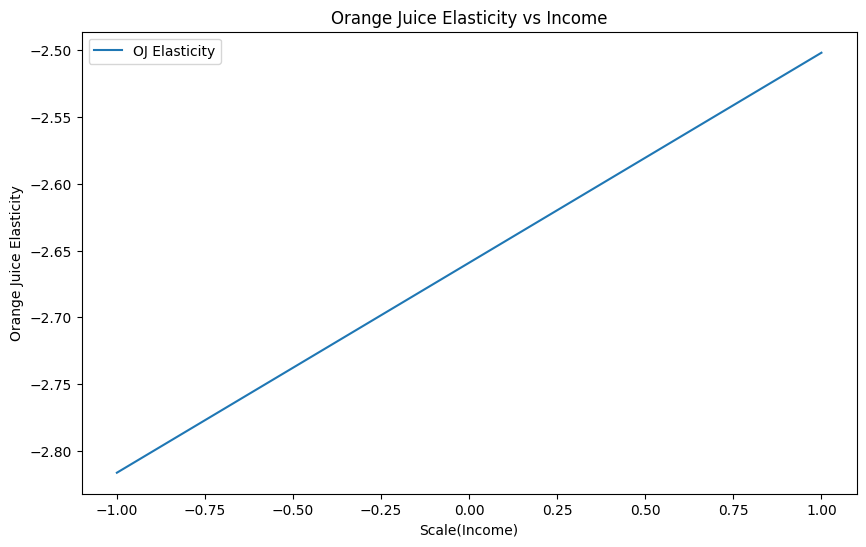

In [53]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(10,6))
plt.plot(X_test, te_pred, label="OJ Elasticity")
plt.xlabel(r'Scale(Income)')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

### 4.4. 置信区间

我们还可以通过向 `fit` 方法传递一个额外的 `inference` 参数来获得预测的置信区间。所有估计器都支持自助法（bootstrap）区间，这涉及在原始数据的子样本上重复拟合相同的估计器，但 `LinearDML` 还支持一种更有效的方法，可以通过将 `inference` 设置为默认值 `'auto'` 或显式传递 `inference='statsmodels'` 来实现。

In [54]:
est.fit(Y, T, X=X, W=W)
te_pred=est.effect(X_test)
te_pred_interval = est.const_marginal_effect_interval(X_test, alpha=0.02)

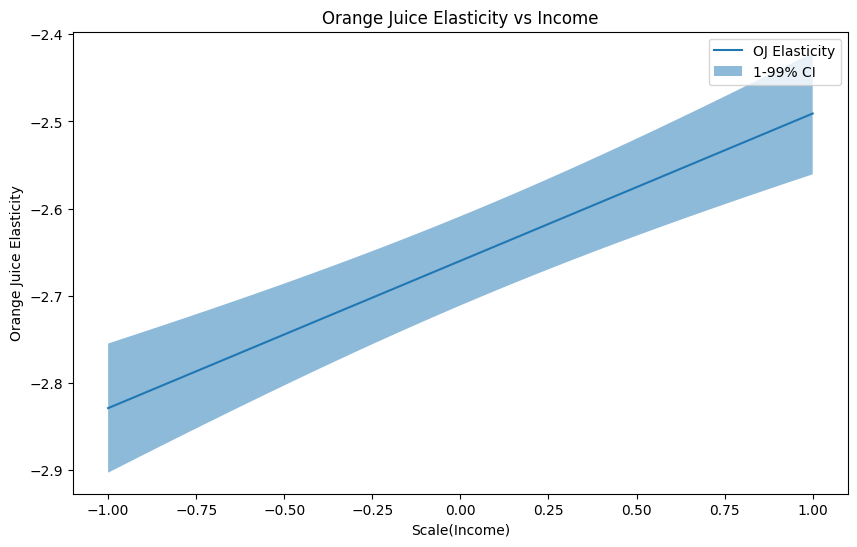

In [55]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(10,6))
plt.plot(X_test.flatten(), te_pred, label="OJ Elasticity")
plt.fill_between(X_test.flatten(), te_pred_interval[0], te_pred_interval[1], alpha=.5, label="1-99% CI")
plt.xlabel(r'Scale(Income)')
plt.ylabel('Orange Juice Elasticity')
plt.title("Orange Juice Elasticity vs Income")
plt.legend()
plt.show()

## 5. 使用多重连续型处理、多重结果的观测数据示例

我们使用相同的数据，但在这种情况下，我们希望拟合多个品牌的需求与它们各自价格的函数关系，即拟合交叉价格弹性矩阵。这可以通过简单地将 $Y$ 设置为需求向量，将 $T$ 设置为价格向量来实现。然后我们可以获得交叉价格弹性矩阵。

\begin{align}
Y=[Logmove_{tropicana},Logmove_{minute.maid},Logmove_{dominicks}] \\
T=[Logprice_{tropicana},Logprice_{minute.maid},Logprice_{dominicks}] \\
\end{align}


### 5.1. 数据

In [56]:
# Import the data
oj_data = pd.read_csv(file_name)

In [57]:
# Prepare data
oj_data['price'] = np.log(oj_data["price"])
# Transform dataset.
# For each store in each week, get a vector of logmove and a vector of logprice for each brand.
# Other features are store specific, will be the same for all brands.
groupbylist = ["store", "week", "AGE60", "EDUC", "ETHNIC", "INCOME",
               "HHLARGE", "WORKWOM", "HVAL150",
               "SSTRDIST", "SSTRVOL", "CPDIST5", "CPWVOL5"]
oj_data1 = pd.pivot_table(oj_data,index=groupbylist,
                          columns=oj_data.groupby(groupbylist).cumcount(),
                          values=['logmove', 'price'],
                          aggfunc='sum').reset_index()
oj_data1.columns = oj_data1.columns.map('{0[0]}{0[1]}'.format)
oj_data1 = oj_data1.rename(index=str,
                           columns={"logmove0": "logmove_T",
                                    "logmove1": "logmove_M",
                                    "logmove2":"logmove_D",
                                    "price0":"price_T",
                                    "price1":"price_M",
                                    "price2":"price_D"})

# Define Y,T,X,W
Y = oj_data1[['logmove_T', "logmove_M", "logmove_D"]].values
T = oj_data1[['price_T', "price_M", "price_D"]].values
scaler = StandardScaler()
W=scaler.fit_transform(oj_data1[[c for c in groupbylist if c not in ['week', 'store', 'INCOME']]].values)
X=scaler.fit_transform(oj_data1[['INCOME']].values)

In [58]:
## Generate test data
min_income = -1
max_income = 1
delta = (1 - (-1)) / 100
X_test = np.arange(min_income, max_income + delta - 0.001, delta).reshape(-1, 1)

### 5.2. 训练估计器

In [59]:
est = LinearDML(model_y=MultiTaskElasticNetCV(cv=3, tol=1, selection='random'),
                model_t=MultiTaskElasticNetCV(cv=3),
                featurizer=PolynomialFeatures(1))
est.fit(Y, T, X=X, W=W)
te_pred = est.const_marginal_effect(X_test)

### 5.3. 性能可视化

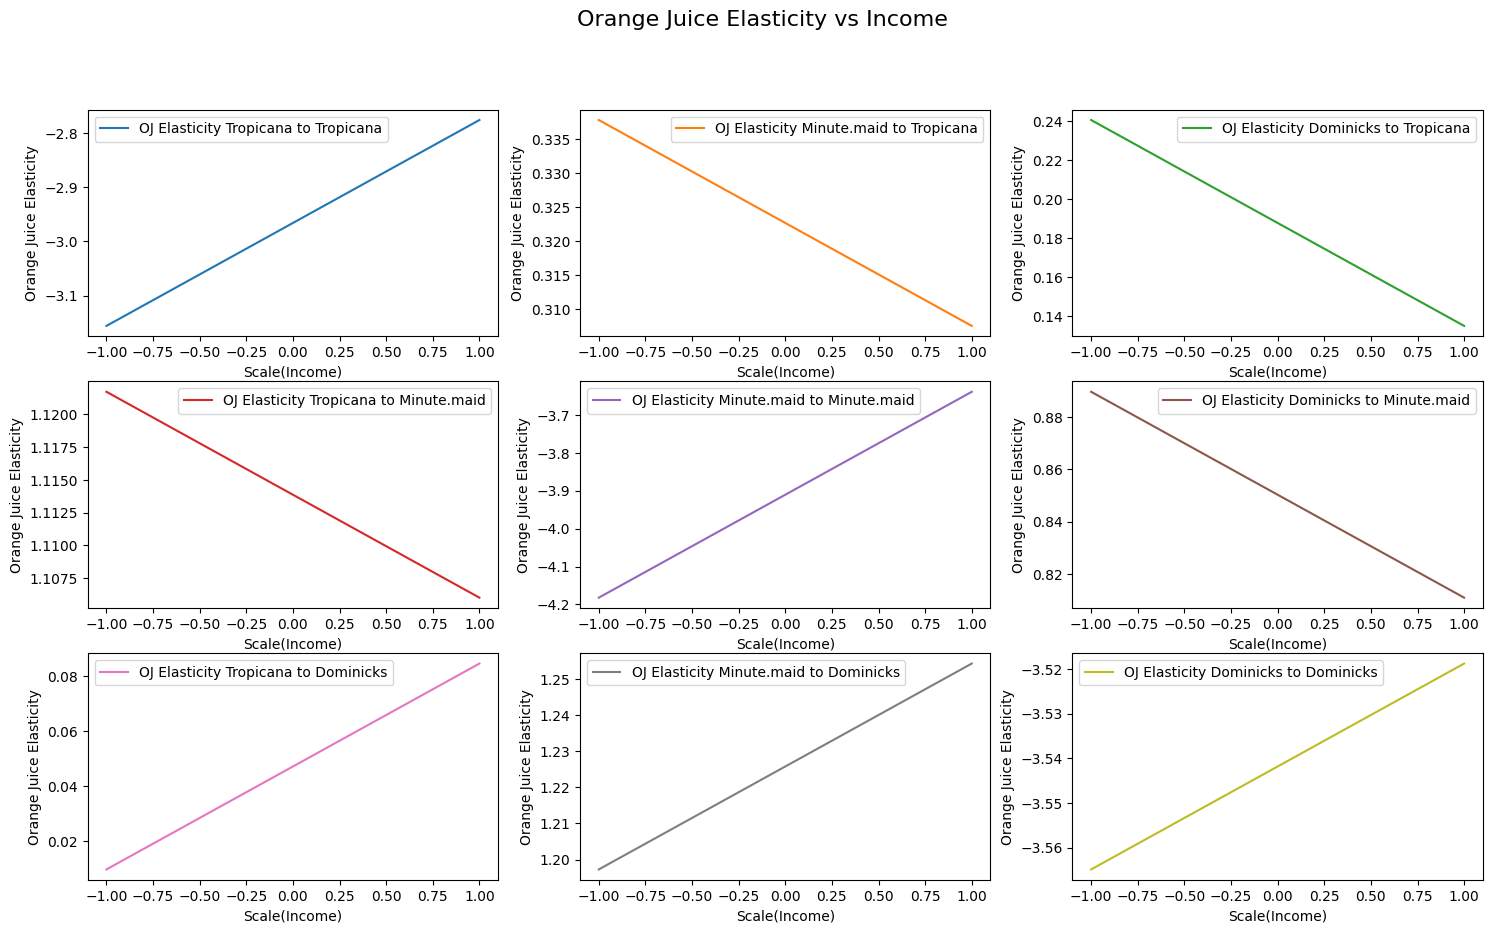

In [60]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(18, 10))
dic={0:"Tropicana", 1:"Minute.maid", 2:"Dominicks"}
for i in range(3):
    for j in range(3):
        plt.subplot(3, 3, 3 * i + j + 1)
        plt.plot(X_test, te_pred[:, i, j],
                 color="C{}".format(str(3 * i + j)),
                 label="OJ Elasticity {} to {}".format(dic[j], dic[i]))
        plt.xlabel(r'Scale(Income)')
        plt.ylabel('Orange Juice Elasticity')
        plt.legend()
plt.suptitle("Orange Juice Elasticity vs Income", fontsize=16)
plt.show()

**研究发现**：观察矩阵的对角线，橙汁价格的处理效应 (TE) 对所有品牌的销售额始终是负相关的，但收入较高的人对价格的敏感度较低。相比之下，对于矩阵的非对角线元素，其他品牌价格的处理效应 (TE) 对该品牌自身的销售额始终是正相关的，且对于不同的竞争对手，该处理效应 (TE) 受收入的影响方式各不相同。此外，与之前的图表相比，每个品牌橙汁价格的负处理效应 (TE) 的绝对值均大于将所有品牌综合考虑时的处理效应 (TE)，这意味着我们可能低估了价格变动对需求的影响。

### 5.4. 置信区间

In [61]:
te_pred_interval = est.const_marginal_effect_interval(X_test, alpha=0.02)

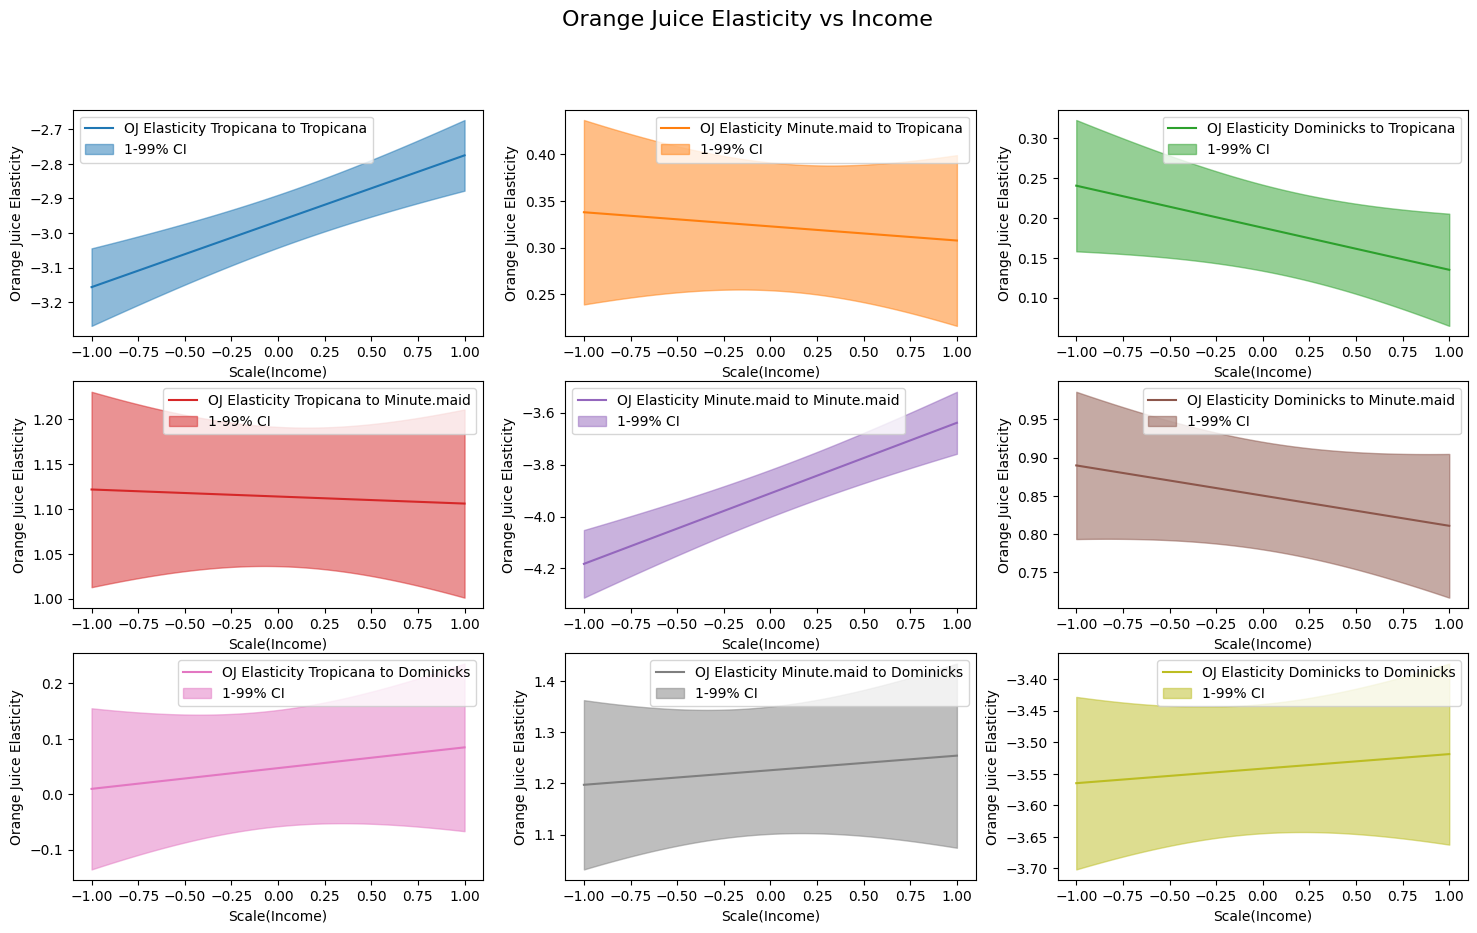

In [62]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(18, 10))
dic={0:"Tropicana", 1:"Minute.maid", 2:"Dominicks"}
for i in range(3):
    for j in range(3):
        plt.subplot(3, 3, 3 * i + j + 1)
        plt.plot(X_test, te_pred[:, i, j],
                 color="C{}".format(str(3 * i + j)),
                 label="OJ Elasticity {} to {}".format(dic[j], dic[i]))
        plt.fill_between(X_test.flatten(),
                         te_pred_interval[0][:, i, j],
                         te_pred_interval[1][:, i,j],
                         color="C{}".format(str(3*i+j)), alpha=.5, label="1-99% CI")
        plt.xlabel(r'Scale(Income)')
        plt.ylabel('Orange Juice Elasticity')
        plt.legend()
plt.suptitle("Orange Juice Elasticity vs Income",fontsize=16)
plt.show()